# Réarrengement data Solordinario

Création d'un dataset à partir de solordinario

In [9]:
import numpy as np
import glob 
import os.path
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

In [10]:
path = 'data'

def listdirectory(path): 
    fichier=[] 
    l = glob.glob(path+'\\*') 
    for i in l: 
        if os.path.isdir(i): fichier.extend(listdirectory(i)) 
        else: fichier.append(i) 
    return fichier

files = listdirectory(path)

In [11]:
long = 3 #durée à conserver en sec
for file in files:
    Fe, sig = wavfile.read(file)
    new_dir = 'data_2/'+file[5:]
    wavfile.write(new_dir, Fe, sig[:long*Fe])

# Dictionnaire avec Pitch et Velocite

(cellules mise en markdown pour éviter un drame)

In [12]:
import descriptors
import torch
import numpy as np

path = 'data_2'
files = listdirectory(path)
nb_files = len(files)
print(nb_files)
sample_per_sec = 250

dict_env = {'file_name' : [[]]*nb_files, 'env' : [[]]*nb_files, 'vel' : [[]]*nb_files, 'pitch' : [[]]*nb_files, 'corde' : [[]]*nb_files}
f = 0

for file in files:
    name = file[7:]
    vel = file[14:16]
    corde = file[17:19]
    if file[-6]=='#':
        pitch = file[-7:-4]
    else :
        pitch = file[-6:-4]
        
    Fe, sig = wavfile.read(file)
    sig = sig.astype(np.float32)
    env = np.zeros([2,long*sample_per_sec])
    env[0,:] = descriptors.extract_loudness(sig, sampling_rate=Fe, block_size=int(Fe/250), n_fft=2048)[:long*sample_per_sec]
    env[1,:] = descriptors.extract_pitch(sig, sampling_rate=Fe, block_size=int(Fe/250))[:long*sample_per_sec]
    
    dict_env['file_name'][f] = file
    dict_env['env'][f] = env
    dict_env['vel'][f] = vel
    dict_env['pitch'][f] = pitch
    dict_env['corde'][f] = corde
    print(f)
    f += 1
  

Save
np.save('data_dict.npy', dict_env) 

Load
dict_r = np.load('data_dict.npy').item() 

# Création dataset pour torch #

format : N * envLoudness * envPitch * vel * note
- N : nombre de samples
- envLoudness : enveloppe d'intensité
- envPitch : enveloppe de fondamentale
- vel : vélocité (1:3)
- note : note midi

In [13]:
import midi_numbers

def convNote2MIDI(noteOct):
    #print(noteOct)
    octave=int(noteOct[len(noteOct)-1])
    note=noteOct[0:len(noteOct)-1]
    midiNote=midi_numbers.note_to_number(note, octave)
    return float(midiNote)

#convNote2MIDI(pitch[0])

def convVel2Nbr(velocity, sym=['pp', 'mf', 'ff']):
    return float(sym.index(velocity)+1)
    
def arrayNote(notes):
    midiNotes=np.zeros((len(notes),))
    
    for ind in range(len(notes)):
        midiNotes[ind]=convNote2MIDI(notes[ind])
    return midiNotes

def arrayVel(velocities):
    nbrVel=np.zeros((len(velocities),))
    for ind in range(len(velocities)):
        nbrVel[ind]=convVel2Nbr(velocities[ind])
    return nbrVel

    


In [17]:
import os
import descriptors
import torch
import numpy as np
N=279
dict_r = np.load('data_dict.npy', allow_pickle=True).item()

train_db = torch.zeros(torch.tensor(dict_r['env']).shape)

#Loudness (normalized) and Pitch envelope 
env=np.array(dict_r["env"])
env[:,0,:]=env[:,0,:]/np.max(np.abs(env[:,0,:]))
#filename
fileName=np.array(dict_r["file_name"]).reshape(N, 1)
#converted velocity and note
pitch=arrayNote(dict_r["pitch"]).reshape(N, 1)
vel=arrayVel(dict_r["vel"]).reshape(N, 1)

corde=np.array(dict_r["corde"]).reshape(N, 1)

#format du dataset : [enveloppes (loudness, pitch), velocitv(pp=1, mf=2, ff=3), note (MIDI)]

train_dataset=torch.utils.data.TensorDataset(torch.from_numpy(env), torch.from_numpy(vel), torch.from_numpy(pitch))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25, shuffle=True)

In [18]:
torch.save(train_dataset, "solordinario_DataSet")

velocity = tensor([2.], dtype=torch.float64)

midi pitch = tensor([72.], dtype=torch.float64)



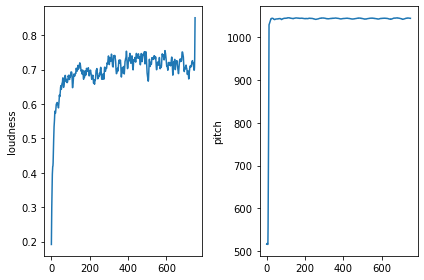

In [19]:
dataset=torch.load("solordinario_DataSet")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)
t1,t2,t3=next(iter(train_loader))
print("velocity = {}\n".format(t2[0]))
print("midi pitch = {}\n".format(t3[0]))
fig=plt.figure()
ax=fig.add_subplot(121)
ax.plot(t1[0,0,:])
ax.set_ylabel("loudness")
ax=fig.add_subplot(122)
ax.plot(t1[0,1,:])
ax.set_ylabel("pitch")
fig.set_tight_layout(True)
